In [8]:
import cv2
import torch
import torchvision
import numpy as np
import utils

import matplotlib.pyplot as plt

import torchvision.transforms.functional
from importlib import reload

In [9]:
img = np.array(cv2.imread('images/castle.jpg'))[...,::-1]/255.0

# values from https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [10]:
model = torchvision.models.vgg16(pretrained=True)
model.eval()

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
Xnp = X.detach().cpu().numpy()

In [12]:
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

In [13]:
A = [X]+[None]*L
for l in range(L):
    A[l+1] = layers[l].forward(A[l])
T = torch.FloatTensor((1.0*(np.arange(1000)==483).reshape([1,1000,1,1])))

In [14]:
R_simp = [None]*L + [(A[-1]*T).data.detach().numpy()]

for l in range(0,L)[::-1]:
    print(f"Layer {l}: {layers[l]}")
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.AvgPool2d):
        kernel_size = layers[l].kernel_size
        R_simp[l] = np.zeros(A[l].shape)

        for chan in range(R_simp[l].shape[1]):
            for i in range(R_simp[l].shape[2]):
                for j in range(R_simp[l].shape[3]):
                    R_simp[l][0,chan,i,j] = A[l][0,chan, i, j] * R_simp[l+1][0,chan,i//kernel_size,j//kernel_size]/(kernel_size*kernel_size)

    elif isinstance(layers[l],torch.nn.Conv2d):
        if l == 0:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9
        elif l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            rho_np = np.vectorize(lambda p: p + 0.25*np.clip(p, a_min=0, a_max=None))
            incr = lambda z: z+1e-9
        elif 17 <= l <= 30:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        elif l >= 31:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9


        R_simp[l] = np.zeros(A[l].shape)

        z = incr(utils.newlayer(layers[l],rho).forward(A[l])).detach().numpy()

        kernel_size = layers[l].kernel_size
        weights = rho_np(layers[l].weight.detach().cpu().numpy())
        padding = layers[l].padding

        if padding == (0, 0):
            padding = (kernel_size[0]-1, kernel_size[1]-1)

        s = R_simp[l+1]/z

        R_pad = np.array([[
            np.pad(x, padding, 'constant', constant_values=(0, 0)) for x in s[0]]])
                    
        a = A[l].detach().cpu().numpy()

        for chan in range(R_simp[l].shape[1]):
            kernel = np.flip(weights[:,chan], axis=(1, 2))
            for i in range(R_simp[l].shape[2]):
                for j in range(R_simp[l].shape[3]):
                    zone = R_pad[0,:,i:i+kernel_size[0],j:j+kernel_size[1]]
                    product = np.tensordot(zone, kernel, axes=3)
                    result = product
                    R_simp[l][0,chan,i,j] = a[0,chan,i,j] * result
        
    else:
        R_simp[l] = R_simp[l+1]

Layer 37: Conv2d(4096, 1000, kernel_size=(1, 1), stride=(1, 1))
Layer 36: Dropout(p=0.5, inplace=False)
Layer 35: ReLU(inplace=True)
Layer 34: Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1))
Layer 33: Dropout(p=0.5, inplace=False)
Layer 32: ReLU(inplace=True)
Layer 31: Conv2d(512, 4096, kernel_size=(7, 7), stride=(1, 1))
Layer 30: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 29: ReLU(inplace=True)
Layer 28: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 27: ReLU(inplace=True)
Layer 26: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 25: ReLU(inplace=True)
Layer 24: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 23: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 22: ReLU(inplace=True)
Layer 21: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 20: ReLU(inplace=True)
Layer 19: Conv2d(512, 512, kernel_size=(3, 3

In [7]:
reload(utils)
for i,l in enumerate(range(31, 0-1, -1)):
    utils.heatmap(np.array(R_simp[l][0]).sum(axis=0),0.1*i+1.5,0.1*i+1.5, title=f"Layer {l} ({type(layers[l]).__name__})")

NameError: name 'R_simp' is not defined

## 2. Abstract semiring

In [12]:
import numbers

class MultipleInitialisation(Exception):
    pass


class MySemiring:
    def handle_initialisation(self, not_none, n1, n2):
        if not_none is not None:
            assert isinstance(
                not_none, numbers.Number
            ), f"must be a number, is of type {type(not_none)}"
            self.value = not_none
            if n1 is not None or n2 is not None:
                raise MultipleInitialisation

    def handle_relevance(self, relevance, n1, n2):
        self.handle_initialisation(relevance, n1, n2)

    def handle_activation(self, activation, n1, n2):
        self.handle_initialisation(activation, n1, n2)

    def handle_weight(self, weight, n1, n2):
        self.handle_initialisation(weight, n1, n2)

    def __init__(self, relevance=None, activation=None, weight=None):
        self.handle_relevance(relevance, activation, weight)
        self.handle_activation(activation, relevance, weight)
        self.handle_weight(weight, activation, relevance)

    def __mul__(self, b):
        f = self.value * b.value
        s = MySemiring()
        s.value = f
        return s

    def to_float(self):
        return self.value

    def __add__(self, b):
        f = self.value + b.value
        s = MySemiring()
        s.value = f
        return s

    def __sub__(self, b):
        f = self.value - b.value
        s = MySemiring()
        s.value = f
        return s

    def pos(self):
        f = max(0, self.value)
        s = MySemiring()
        s.value = f
        return s

    def neg(self):
        f = min(0, self.value)
        s = MySemiring()
        s.value = f
        return s

    def lower_bound(shape, bound):
        return np.vectorize(MySemiring.from_activation)(bound * np.ones(shape))

    def upper_bound(shape, bound):
        return np.vectorize(MySemiring.from_activation)(bound * np.ones(shape))

    from_activation = np.vectorize(lambda x: MySemiring(activation=x))
    from_weight = np.vectorize(lambda x: MySemiring(weight=x))
    vect_pos = np.vectorize(lambda x: x.pos())
    vect_neg = np.vectorize(lambda x: x.neg())

    def from_relevance(m):
        return np.array(
            [
                [
                    [
                        [
                            MySemiring(activation=m[x][y][z][a]) 
                            for a in range(m.shape[3])
                        ]
                        for z in range(m.shape[2])
                    ]
                    for y in range(m.shape[1])
                ]
                for x in range(m.shape[0])
            ]
        )

    def semiring_to_float(m):
        return np.array(
            [
                [
                    [
                        [
                            m[x][y][z][a].to_float() 
                            for a in range(m.shape[3])
                        ]
                        for z in range(m.shape[2])
                    ]
                    for y in range(m.shape[1])
                ]
                for x in range(m.shape[0])
            ]
        )

    def __repr__(self):
        return f"{self.__class__.__name__}({self.value})"

In [11]:
semiring = MySemiring

R_semi = [None]*L + [semiring.from_relevance((A[-1]*T).data.detach().numpy())]

for l in range(0,L)[::-1]:
    print(f"Layer {l}: {layers[l]}")
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.AvgPool2d):
        kernel_size = layers[l].kernel_size
        R_semi[l] = np.zeros(A[l].shape)

        for chan in range(R_semi[l].shape[1]):
            for i in range(R_semi[l].shape[2]):
                for j in range(R_semi[l].shape[3]):
                    R_semi[l][0,chan,i,j] = semiring.from_activation(A[l][0,chan, i, j]) * R_semi[l+1][0,chan,i//kernel_size,j//kernel_size]#/(kernel_size*kernel_size)

    elif isinstance(layers[l],torch.nn.Conv2d):
        if l == 0:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9
        elif l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            rho_np = np.vectorize(lambda p: p + 0.25*np.clip(p, a_min=0, a_max=None))
            incr = lambda z: z+1e-9
        elif 17 <= l <= 30:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        elif l >= 31:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9


        R_semi[l] = np.zeros(A[l].shape, dtype=object)
        a = A[l].detach().cpu().numpy()

        kernel_size = layers[l].kernel_size
        weights = rho_np(layers[l].weight.detach().cpu().numpy())
        
        # Padding
        padding = layers[l].padding

        if padding == (0, 0):
            padding = (kernel_size[0]-1, kernel_size[1]-1)

        # LRP
        z = incr(utils.newlayer(layers[l],rho).forward(A[l])).detach().numpy()
        s = R_semi[l+1]#/z

        zero = MySemiring(relevance=0)
        R_pad = np.array([[
            np.pad(x, padding, 'constant', constant_values=(zero, zero)) for x in s[0]]])
        for chan in range(R_semi[l].shape[1]):
            if l == 31:
                print(f"Channel {chan+1}/{R_semi[l].shape[1]}")
            kernel = np.flip(weights[:,chan], axis=(1, 2))
            kernel = semiring.from_weight(kernel)
            for i in range(R_semi[l].shape[2]):
                for j in range(R_semi[l].shape[3]):
                    zone = R_pad[0,:,i:i+kernel_size[0],j:j+kernel_size[1]]
                    product = np.tensordot(zone, kernel, axes=3)
                    result = product
                    R_semi[l][0,chan,i,j] = semiring.from_activation(a[0,chan,i,j]) * result
        
    else:
        R_semi[l] = R_semi[l+1]

NameError: name 'MySemiring' is not defined

In [19]:
UPTO = 30

In [55]:
theta_r = 1e-9
theta_a = 1
theta_w = -1

R_bool = [None]*L + [np.vectorize(lambda x: x>=theta_r)((A[-1]*T).data.detach().numpy())]

for l in range(UPTO,L)[::-1]:
    print(f"Layer {l}: {layers[l]}")
    A[l] = (A[l].data).requires_grad_(True)
    a = A[l].detach().cpu().numpy() >= theta_a

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.AvgPool2d):
        kernel_size = layers[l].kernel_size
        R_bool[l] = np.zeros(A[l].shape)

        for chan in range(R_bool[l].shape[1]):
            for i in range(R_bool[l].shape[2]):
                for j in range(R_bool[l].shape[3]):
                    # TODO: optimize?
                    R_bool[l][0,chan,i,j] = a[0,chan, i, j] and R_bool[l+1][0,chan,i//kernel_size,j//kernel_size]#/(kernel_size*kernel_size)

    elif isinstance(layers[l],torch.nn.Conv2d):
        if l == 0:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z#+1e-9
        elif l <= 16:
            rho = lambda p: p #+ 0.25*p.clamp(min=0)
            rho_np = lambda p: p #+ 0.25*np.clip(p, a_min=0, a_max=None))
            incr = lambda z: z#+1e-9
        elif 17 <= l <= 30:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z#+1e-9+0.25*((z**2).mean()**.5).data
        elif l >= 31:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z#+1e-9


        R_bool[l] = np.zeros(A[l].shape, dtype=bool)

        kernel_size = layers[l].kernel_size
        weights = rho_np(layers[l].weight.detach().cpu().numpy())
        weights = weights >= theta_w

        
        # Padding
        padding = layers[l].padding

        if padding == (0, 0):
            padding = (kernel_size[0]-1, kernel_size[1]-1)

        # LRP
        z = incr(utils.newlayer(layers[l],rho).forward(A[l])).detach().numpy()
        s = R_bool[l+1]#/z

        zero = False
        R_pad = np.array([[
            np.pad(x, padding, 'constant', constant_values=(zero, zero)) for x in s[0]]])
        for chan in range(R_bool[l].shape[1]):
            kernel = np.flip(weights[:,chan], axis=(1, 2))
            for i in range(R_bool[l].shape[2]):
                for j in range(R_bool[l].shape[3]):
                    zone = R_pad[0,:,i:i+kernel_size[0],j:j+kernel_size[1]]
                    product = (zone*kernel).sum() > 0
                    R_bool[l][0,chan,i,j] = a[0,chan,i,j] and product
                    #R_bool[l][0,chan,i,j] = product
        
    else:
        R_bool[l] = R_bool[l+1]

Layer 37: Conv2d(4096, 1000, kernel_size=(1, 1), stride=(1, 1))
Layer 36: Dropout(p=0.5, inplace=False)
Layer 35: ReLU(inplace=True)
Layer 34: Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1))
Layer 33: Dropout(p=0.5, inplace=False)
Layer 32: ReLU(inplace=True)
Layer 31: Conv2d(512, 4096, kernel_size=(7, 7), stride=(1, 1))
Layer 30: AvgPool2d(kernel_size=2, stride=2, padding=0)


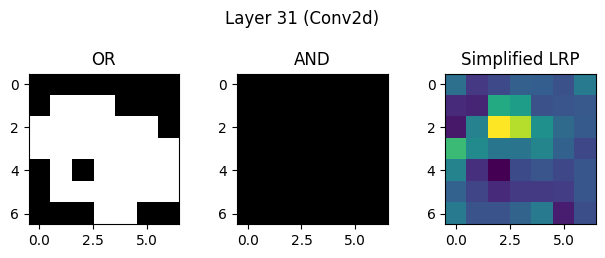

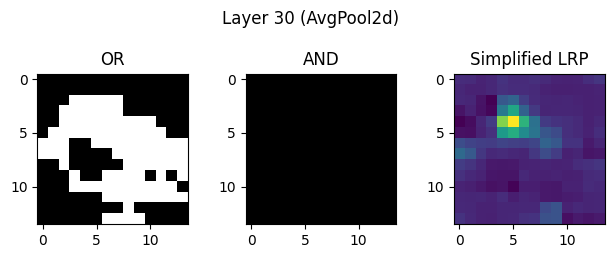

TypeError: 'NoneType' object is not subscriptable

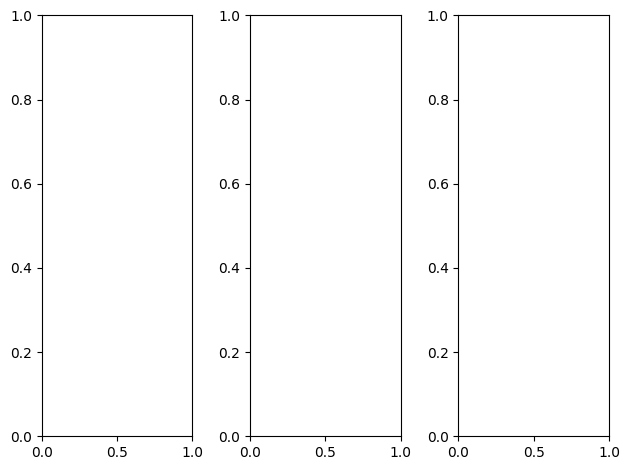

In [71]:
for l in range(UPTO,31+1)[::-1]:
    fig, axs = plt.subplots(1,3)
    # fig, axs = plt.subplots(1,5,figsize=(10, 5))
    fig.tight_layout()

    #cmaps = ["Reds", "Greens", "Blues"]

    #for i in range(3):
    #    axs[i].imshow(R_bool[l][0][i], cmap=cmaps[i])
    #    axs[i].set_title(f"Channel {i}")
        
    axs[0].imshow((R_bool[l][0][0] + R_bool[l][0][1] + R_bool[l][0][2])>0, cmap="gray")
    axs[0].set_title("OR")
    axs[1].imshow((R_bool[l][0][0] * R_bool[l][0][1] * R_bool[l][0][2])>0, cmap="gray")
    axs[1].set_title("AND")

    axs[2].imshow(R_simp[l][0].sum(axis=0))
    axs[2].set_title("Simplified LRP")

    plt.suptitle(f"Layer {l} ({type(layers[l]).__name__})")
    plt.subplots_adjust(top=1.3)
    plt.show()

## 3. New rule

In [110]:
UPTO = 14
print(UPTO)

14


In [116]:
R_new_bool = [None]*L + [(A[-1]*T).data.detach().numpy() > 0]

thetas = {
    0: 0,
    2: 0,
    5: 0,
    7: 0,
    10: 0,
    12: 0,
    14: .9,
    17: .9,
    19: .9,
    21: .7,
    24: .8,
    26: .7,
    28: .35,
    31: .15,
    34: .15,
    37: .15
}

for l in range(UPTO,L)[::-1]:
    print(f"Layer {l}: {layers[l]}")
    A[l] = (A[l].data).requires_grad_(True)
    a = A[l].detach().cpu().numpy()

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.AvgPool2d):
        kernel_size = layers[l].kernel_size
        R_new_bool[l] = np.zeros(A[l].shape)

        for chan in range(R_new_bool[l].shape[1]):
            for i in range(R_new_bool[l].shape[2]):
                for j in range(R_new_bool[l].shape[3]):
                    # TODO: optimize?
                    R_new_bool[l][0,chan,i,j] = (a[0,chan, i, j]>=1e-9) and R_new_bool[l+1][0,chan,i//kernel_size,j//kernel_size]
                    #R_new_bool[l][0,chan,i,j] = R_new_bool[l+1][0,chan,i//kernel_size,j//kernel_size]

    elif isinstance(layers[l],torch.nn.Conv2d):
        if l == 0:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9
        elif l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            rho_np = lambda p: p + 0.25*np.clip(p, a_min=0, a_max=None)
            incr = lambda z: z+1e-9
        elif 17 <= l <= 30:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            #theta = .35
        elif l >= 31:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9
            #theta = .15


        R_new_bool[l] = np.zeros(A[l].shape, dtype=bool)

        kernel_size = layers[l].kernel_size
        weights = rho_np(layers[l].weight.detach().cpu().numpy())
        #weights = weights >= theta_w

        
        # Padding
        padding = layers[l].padding

        if padding == (0, 0):
            padding = (kernel_size[0]-1, kernel_size[1]-1)

        # LRP
        z = incr(utils.newlayer(layers[l],rho).forward(A[l])).detach().numpy()
        #zpad = np.array([[np.pad(x, padding, 'constant', constant_values=(1, 1)) for x in z[0]]])
        #iz = 1/zpad
        s = R_new_bool[l+1]#/z

        zero = False
        R_pad = np.array([[np.pad(x, padding, 'constant', constant_values=(zero, zero)) for x in s[0]]])
        for chan in range(R_new_bool[l].shape[1]):
            kernel = np.flip(weights[:,chan], axis=(1, 2))
            for i in range(R_new_bool[l].shape[2]):
                for j in range(R_new_bool[l].shape[3]):
                    dkernel = a[0,chan,i,j] * kernel
                    #dkernel = iz[0,:,i:i+kernel_size[0],j:j+kernel_size[1]] * dkernel
                    dkernel = np.abs(dkernel) > thetas[l]

                    zone = R_pad[0,:,i:i+kernel_size[0],j:j+kernel_size[1]]
                    product = (zone*dkernel).sum()
                    #R_new_bool[l][0,chan,i,j] = (a[0,chan, i, j]>=.5) and product
                    R_new_bool[l][0,chan,i,j] = product
        
    else:
        R_new_bool[l] = R_new_bool[l+1]

Layer 37: Conv2d(4096, 1000, kernel_size=(1, 1), stride=(1, 1))
Layer 36: Dropout(p=0.5, inplace=False)
Layer 35: ReLU(inplace=True)
Layer 34: Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1))
Layer 33: Dropout(p=0.5, inplace=False)
Layer 32: ReLU(inplace=True)
Layer 31: Conv2d(512, 4096, kernel_size=(7, 7), stride=(1, 1))
Layer 30: AvgPool2d(kernel_size=2, stride=2, padding=0)
Layer 29: ReLU(inplace=True)
Layer 28: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 27: ReLU(inplace=True)
Layer 26: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 25: ReLU(inplace=True)
Layer 24: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 23: AvgPool2d(kernel_size=2, stride=2, padding=0)
Layer 22: ReLU(inplace=True)
Layer 21: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 20: ReLU(inplace=True)
Layer 19: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 18: ReLU(inplace=T

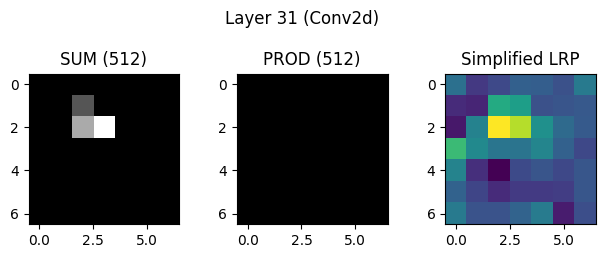

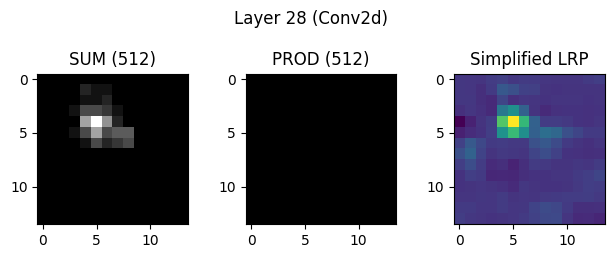

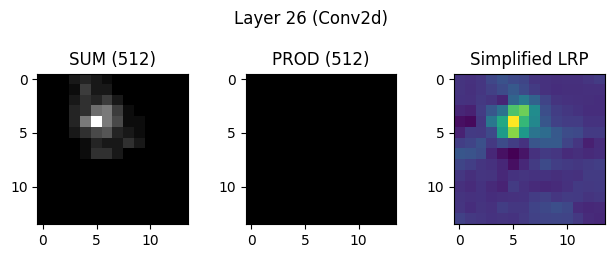

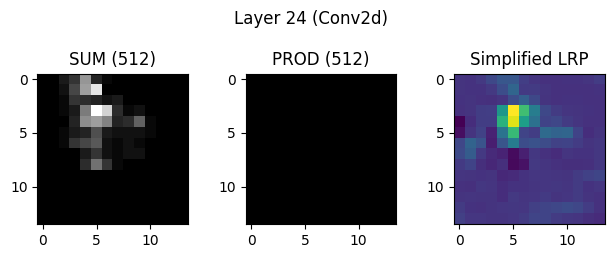

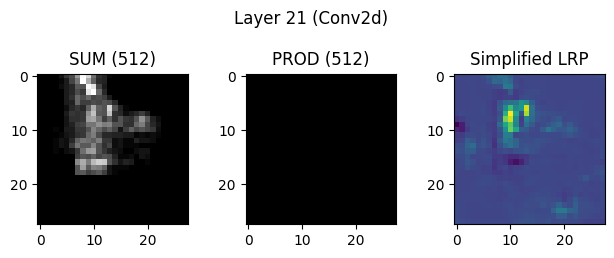

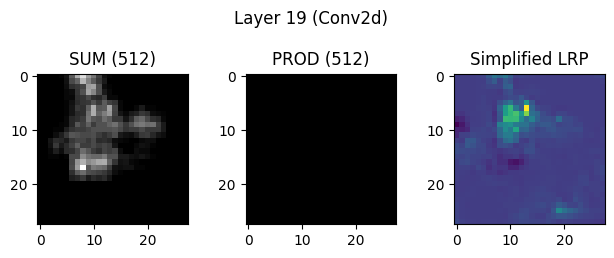

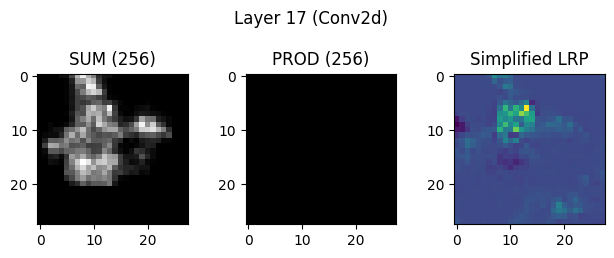

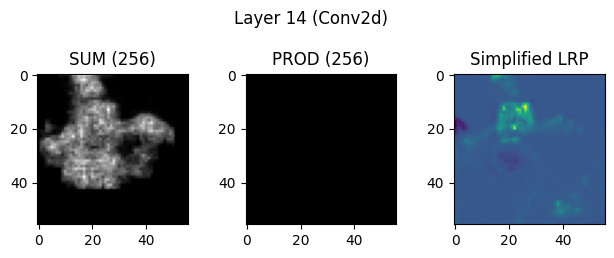

In [118]:
for l in range(UPTO,31+1)[::-1]:
    if type(layers[l]).__name__ != "Conv2d":
        continue
    fig, axs = plt.subplots(1,3)
    # fig, axs = plt.subplots(1,5,figsize=(10, 5))
    fig.tight_layout()

    #cmaps = ["Reds", "Greens", "Blues"]

    #for i in range(3):
    #    axs[i].imshow(R_bool[l][0][i], cmap=cmaps[i])
    #    axs[i].set_title(f"Channel {i}")
        
    axs[0].imshow(R_new_bool[l][0].sum(axis=0), cmap="gray")
    axs[0].set_title(f"SUM ({A[l].shape[1]})")
    axs[1].imshow(R_new_bool[l][0].prod(axis=0), cmap="gray")
    axs[1].set_title(f"PROD ({A[l].shape[1]})")

    axs[2].imshow(R_simp[l][0].sum(axis=0))
    axs[2].set_title("Simplified LRP")

    plt.suptitle(f"Layer {l} ({type(layers[l]).__name__})")
    plt.subplots_adjust(top=1.3)
    plt.show()

## 4. With normalization

In [15]:
UPTO = 0
print(UPTO)

0


In [16]:
R_new_bool = [None]*L + [(A[-1]*T).data.detach().numpy() > 0]

thetas = {
    0: .05,
    2: .05,
    5: .05,
    7: .05,
    10: .05,
    12: .05,
    14: .06,
    17: .06,
    19: .06,
    21: .1,
    24: .09,
    26: .025,
    28: .3,
    31: .043,
    34: .0145,
    37: .0145
}

for l in range(UPTO,L)[::-1]:
    print(f"Layer {l}: {layers[l]}")
    A[l] = (A[l].data).requires_grad_(True)
    a = A[l].detach().cpu().numpy()

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.AvgPool2d):
        kernel_size = layers[l].kernel_size
        R_new_bool[l] = np.zeros(A[l].shape)

        for chan in range(R_new_bool[l].shape[1]):
            for i in range(R_new_bool[l].shape[2]):
                for j in range(R_new_bool[l].shape[3]):
                    # TODO: optimize?
                    R_new_bool[l][0,chan,i,j] = (a[0,chan, i, j]>=1e-9) and R_new_bool[l+1][0,chan,i//kernel_size,j//kernel_size]
                    #R_new_bool[l][0,chan,i,j] = R_new_bool[l+1][0,chan,i//kernel_size,j//kernel_size]

    elif isinstance(layers[l],torch.nn.Conv2d):
        if l == 0:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9
        elif l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            rho_np = lambda p: p + 0.25*np.clip(p, a_min=0, a_max=None)
            incr = lambda z: z+1e-9
        elif 17 <= l <= 30:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        elif l >= 31:
            rho = lambda p: p
            rho_np = rho
            incr = lambda z: z+1e-9


        R_new_bool[l] = np.zeros(A[l].shape, dtype=bool)

        kernel_size = layers[l].kernel_size
        weights = rho_np(layers[l].weight.detach().cpu().numpy())
        #weights = weights >= theta_w

        
        # Padding
        padding = layers[l].padding

        if padding == (0, 0):
            padding = (kernel_size[0]-1, kernel_size[1]-1)

        # LRP
        z = incr(utils.newlayer(layers[l],rho).forward(A[l])).detach().numpy()
        iz = 1/z
        iz = np.array([[np.pad(x, padding, 'constant', constant_values=(1, 1)) for x in iz[0]]])

        zero = False
        R_pad = np.array([[np.pad(x, padding, 'constant', constant_values=(zero, zero)) for x in R_new_bool[l+1][0]]])
        for chan in range(R_new_bool[l].shape[1]):
            kernel = np.flip(weights[:,chan], axis=(1, 2))
            for i in range(R_new_bool[l].shape[2]):
                for j in range(R_new_bool[l].shape[3]):
                    dkernel = a[0,chan,i,j] * kernel
                    dkernel = iz[0,:,i:i+kernel_size[0],j:j+kernel_size[1]] * dkernel
                    dkernel = np.abs(dkernel) > thetas[l]

                    zone = R_pad[0,:,i:i+kernel_size[0],j:j+kernel_size[1]]
                    product = (zone*dkernel).sum()
                    #R_new_bool[l][0,chan,i,j] = (a[0,chan, i, j]>=.5) and product
                    R_new_bool[l][0,chan,i,j] = product
        
    else:
        R_new_bool[l] = R_new_bool[l+1]

Layer 37: Conv2d(4096, 1000, kernel_size=(1, 1), stride=(1, 1))
Layer 36: Dropout(p=0.5, inplace=False)
Layer 35: ReLU(inplace=True)
Layer 34: Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1))
Layer 33: Dropout(p=0.5, inplace=False)
Layer 32: ReLU(inplace=True)
Layer 31: Conv2d(512, 4096, kernel_size=(7, 7), stride=(1, 1))
Layer 30: AvgPool2d(kernel_size=2, stride=2, padding=0)
Layer 29: ReLU(inplace=True)
Layer 28: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 27: ReLU(inplace=True)
Layer 26: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 25: ReLU(inplace=True)
Layer 24: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 23: AvgPool2d(kernel_size=2, stride=2, padding=0)
Layer 22: ReLU(inplace=True)
Layer 21: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 20: ReLU(inplace=True)
Layer 19: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 18: ReLU(inplace=T

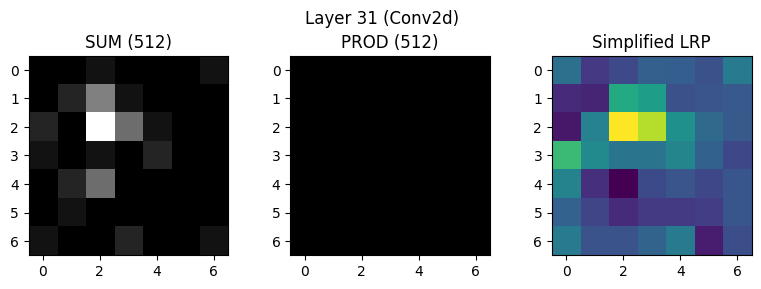

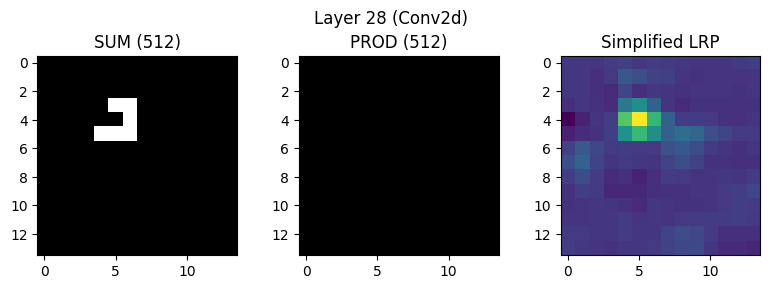

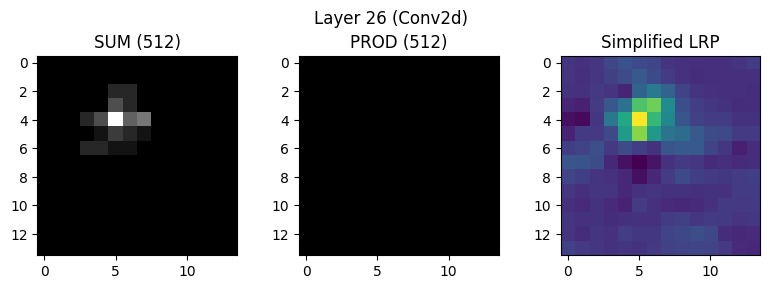

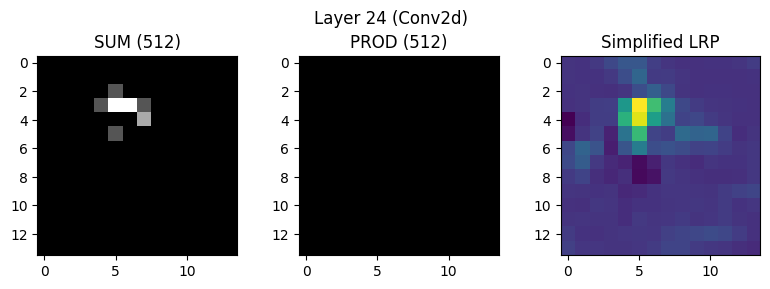

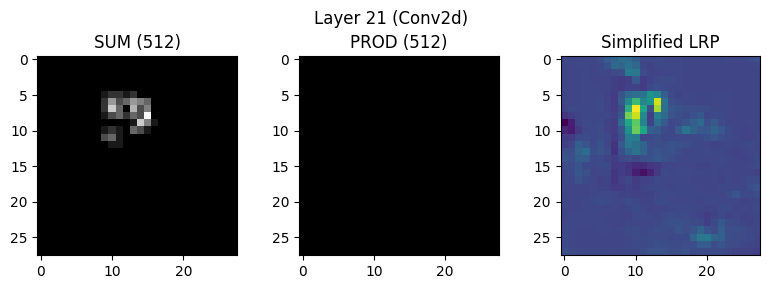

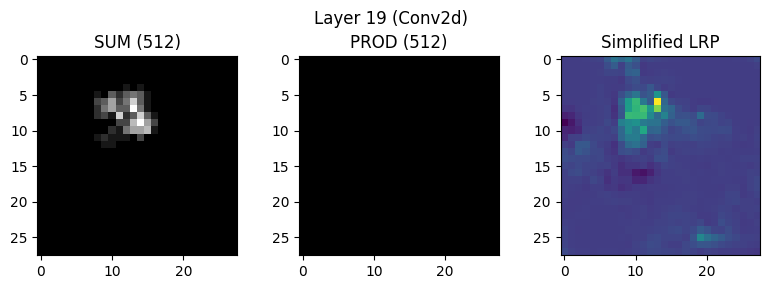

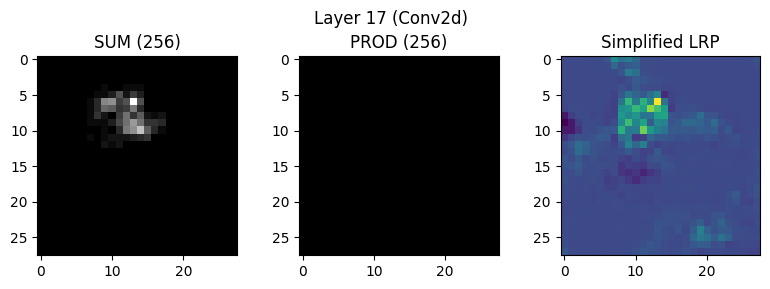

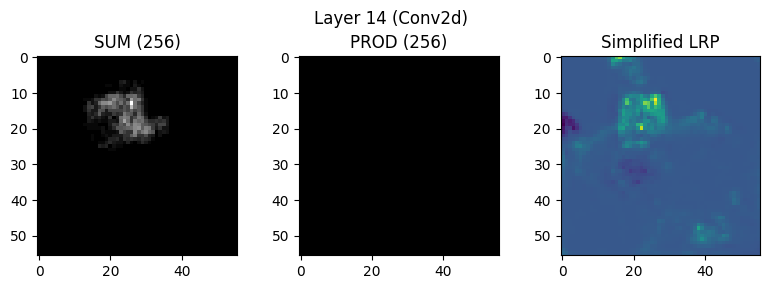

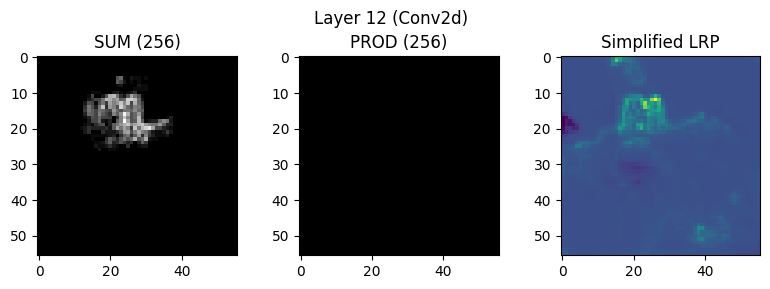

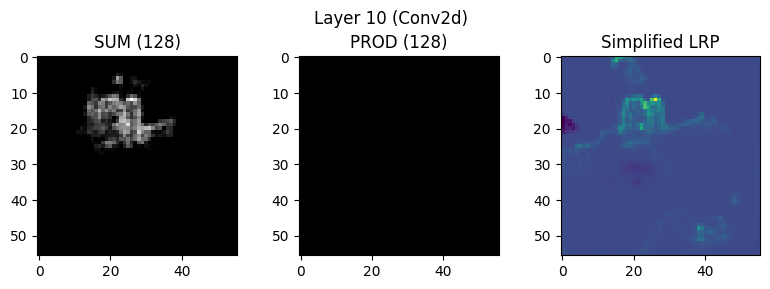

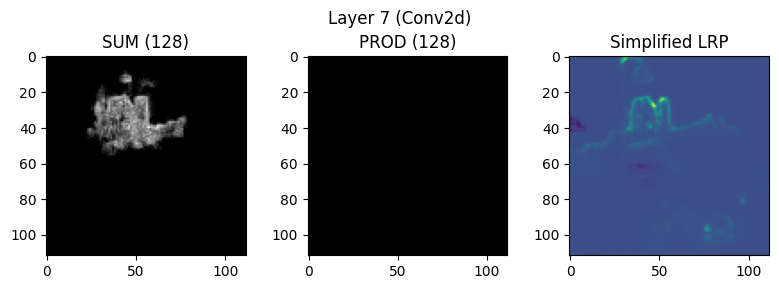

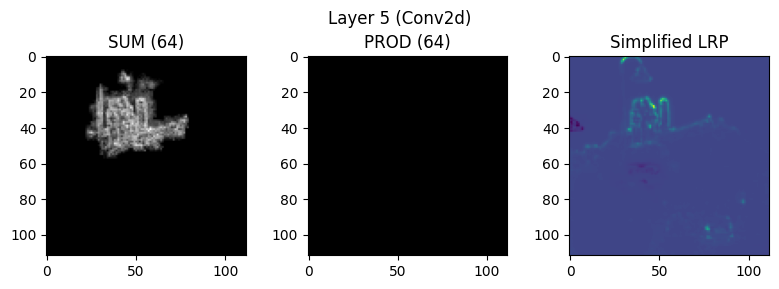

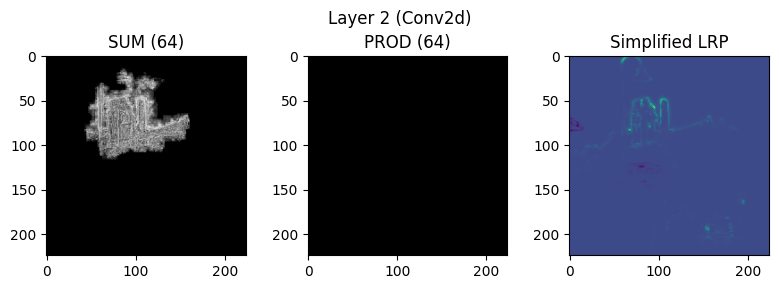

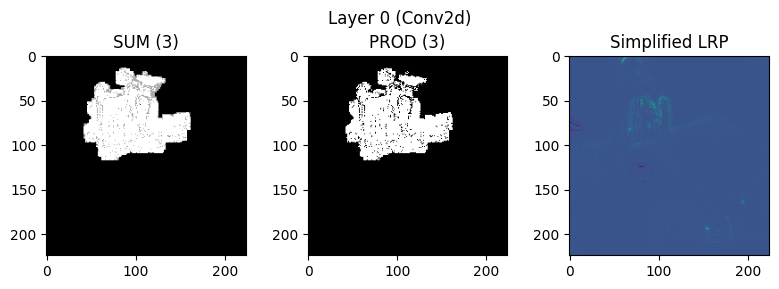

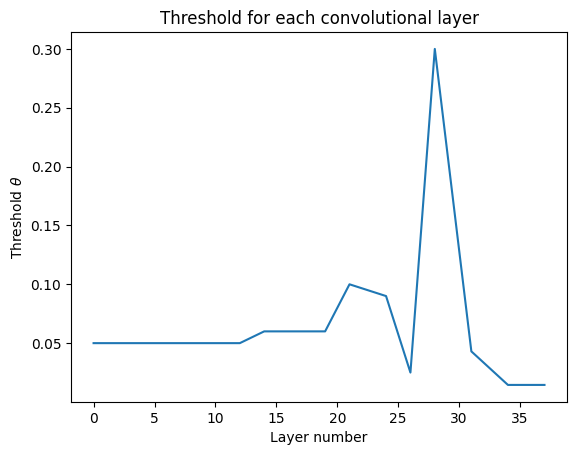

In [19]:
for l in range(UPTO,31+1)[::-1]:
    if type(layers[l]).__name__ != "Conv2d":
        continue
    fig, axs = plt.subplots(1,3, figsize=(8, 5))
    fig.tight_layout()
        
    axs[0].imshow(R_new_bool[l][0].sum(axis=0), cmap="gray")
    axs[0].set_title(f"SUM ({A[l].shape[1]})")
    axs[1].imshow(R_new_bool[l][0].prod(axis=0), cmap="gray")
    axs[1].set_title(f"PROD ({A[l].shape[1]})")

    axs[2].imshow(R_simp[l][0].sum(axis=0))
    axs[2].set_title("Simplified LRP")

    plt.suptitle(f"Layer {l} ({type(layers[l]).__name__})")
    plt.subplots_adjust(top=1.3)
    plt.show()

plt.plot(list(thetas), list(thetas.values()))
plt.xlabel("Layer number")
plt.ylabel("Threshold $\\theta$")
plt.title("Threshold for each convolutional layer")
plt.show()

## 5. MobileNet_v3_small

In [12]:
img = np.array(cv2.imread('images/castle.jpg'))[...,::-1]/255.0

# values from https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std
Xnp = X.detach().cpu().numpy()

In [13]:
model = torchvision.models.densenet121(pretrained=True)
model.eval()

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:
layers = [model._modules['features']] + [model._modules['classifier']]
L = len(layers)

In [15]:
list(model.named_modules())

[('',
  DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True,

In [16]:
model._modules.keys()

odict_keys(['features', 'classifier'])

In [17]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (7168x7 and 1024x1000)

In [ ]:
scores = np.array(model(X).detach().numpy().view(-1))
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

TypeError: Cannot interpret '-1' as a data type